In [1]:
# DL framework
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

from datetime import datetime

# common packages
import numpy as np
import os # handling file i/o
import sys
import math
import time # timing epochs

# for ordered dict when building layer components
import collections

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import colors # making colors consistent
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar helper

# read image
from imageio import imread
# + data augmentation
from scipy import ndimage
from scipy import misc

# used for manually saving best params
import pickle

# for shuffling data batches
from sklearn.utils import shuffle

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# helper to create dirs if they don't already exist
def maybe_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} createed".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
    
# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Important Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.5.0-dev20171220
No GPU found


In [2]:
# `/output_images` will hold, you guessed it, output images
INPUT_DIR = "../../ROOT_DATA/dependencies"
OUTPUT_DIR = "./output_images"
maybe_create_dir(OUTPUT_DIR)

./output_images already exists


In [3]:
def implot(img, ax):
    im = ax.imshow(img.astype(np.uint8), interpolation="nearest")
    #ax.set_axis_off()
    
def implot_gs(img, ax):
    im = ax.imshow(img.astype(np.uint8), interpolation="nearest", cmap='gray')
    #ax.set_axis_off()
    
# helper to plot images side-by-side, and save, if requested
def plot_side_by_side(image_a, image_b, SAVE_FIG_TO_OUTPUT=None, GRAYCM=True):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(16,8))

    if GRAYCM:
        implot_gs(image_a, ax1)
        implot_gs(image_b, ax2)
    else:
        implot(image_a, ax1)
        implot(image_b, ax2)

    plt.grid('off')
    plt.tight_layout()
    
    if SAVE_FIG_TO_OUTPUT:
        name_str = '{}.png'.format(SAVE_FIG_TO_OUTPUT)
        plt.savefig(os.path.join(OUTPUT_DIR, name_str), dpi=300)
        print(name_str + " saved to disk")
    
    plt.show()

def plot_single_image(image, SAVE_FIG_TO_OUTPUT=None, GRAYCM=True):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10,10))
    if GRAYCM:
        implot_gs(image, ax1)
    else:
        implot(image, ax1)
    plt.grid('off')
    plt.tight_layout()
    if SAVE_FIG_TO_OUTPUT:
        name_str = '{}.png'.format(SAVE_FIG_TO_OUTPUT)
        plt.savefig(os.path.join(OUTPUT_DIR, name_str), dpi=300)
        print(name_str + " saved to disk")
    
    plt.show()

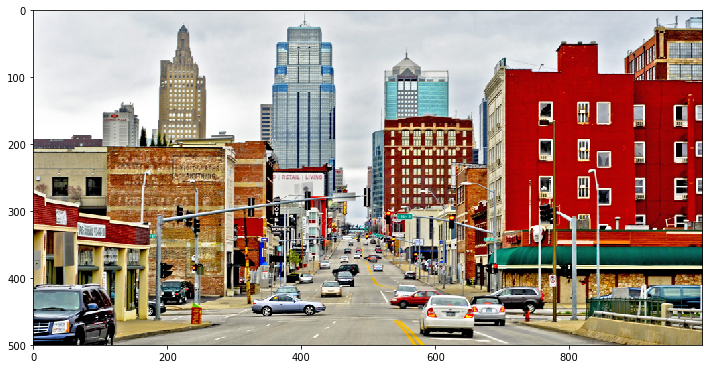

(500, 999, 3)


In [4]:
image_name = "Grand_Blvd_Kansas_City.jpg"
img_path = os.path.join(INPUT_DIR, image_name)
image_raw = imread(img_path)
plot_single_image(image_raw)
print(image_raw.shape)

In [5]:
# preprocess image (basic cropping)
# image dimensions (GLOBAL) - [MG_WIDTH x IMG_HEIGHT, CHANNELS]
SQUARE_DIM = 450
if SQUARE_DIM:
    IMG_WIDTH = SQUARE_DIM
    IMG_HEIGHT = SQUARE_DIM
CHANNELS = 3

def quick_approx_crop(image, square_size):
    height, width, channels = image.shape
    xoff = (width - square_size) // 2
    yoff = (height - square_size) // 2
    # quick and dirty way to handle img that has odd dim size
    w_adj = 0
    h_adj = 0
    if width % 2 != 0:
        w_adj += 1
    if height % 2 != 0:
        h_adj += 1
    img_cropped = image[yoff+h_adj:-yoff,xoff+w_adj:-xoff]
    return img_cropped

# convert to grayscale
# https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
# > `Y' = 0.299 R + 0.587 G + 0.114 B `
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

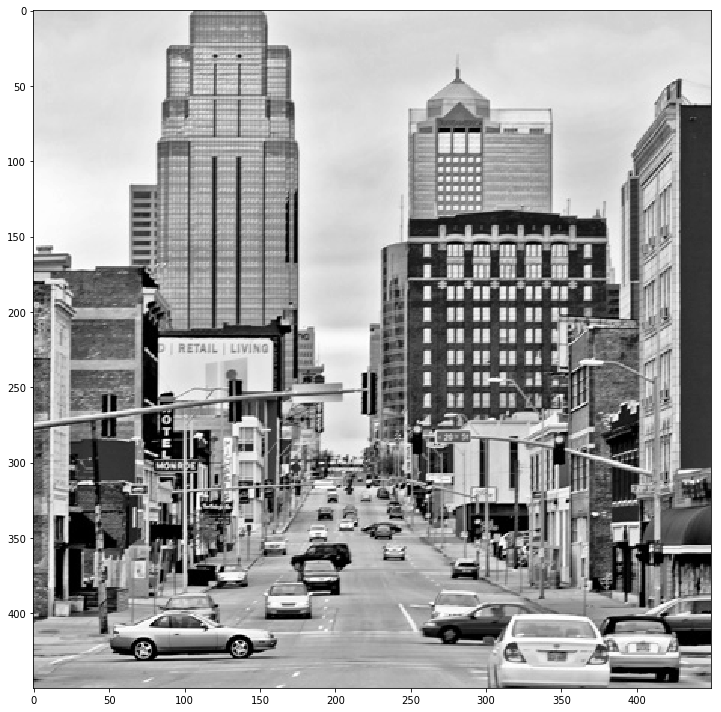

217.69
(450, 450)


In [6]:
# crop image
cropped_img = quick_approx_crop(image_raw, SQUARE_DIM)
img = rgb2gray(cropped_img)

plot_single_image(img)
print(img[200][200])
print(img.shape)

In [7]:
# single channel
img = np.expand_dims(img, axis=-1)
# "batch"
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 450, 450, 1)


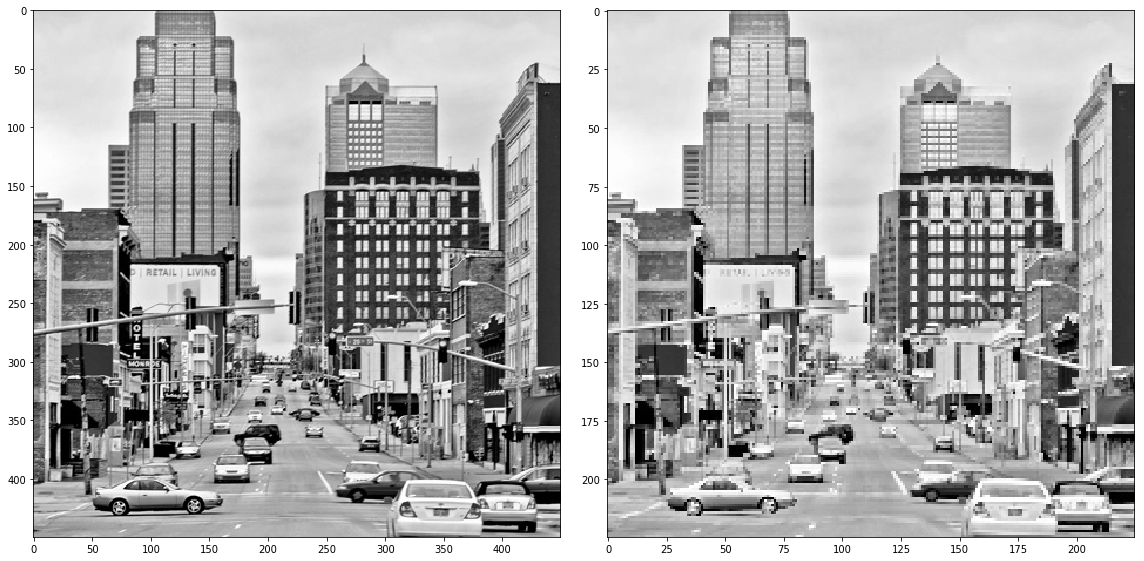

In [8]:
max_pool_out = tf.nn.max_pool(img, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
plot_side_by_side(img[0][:,:,0], np.asarray(max_pool_out[0][:,:,0]))

## Notice the size!
We've gone from 450x450 to 225x225 (using a kernel of size 2 and a stride of size 2)


But so now I bet you're wondering what happens if we use a pooling layer again with an odd input size? Well.... let's see (hint, think padding)

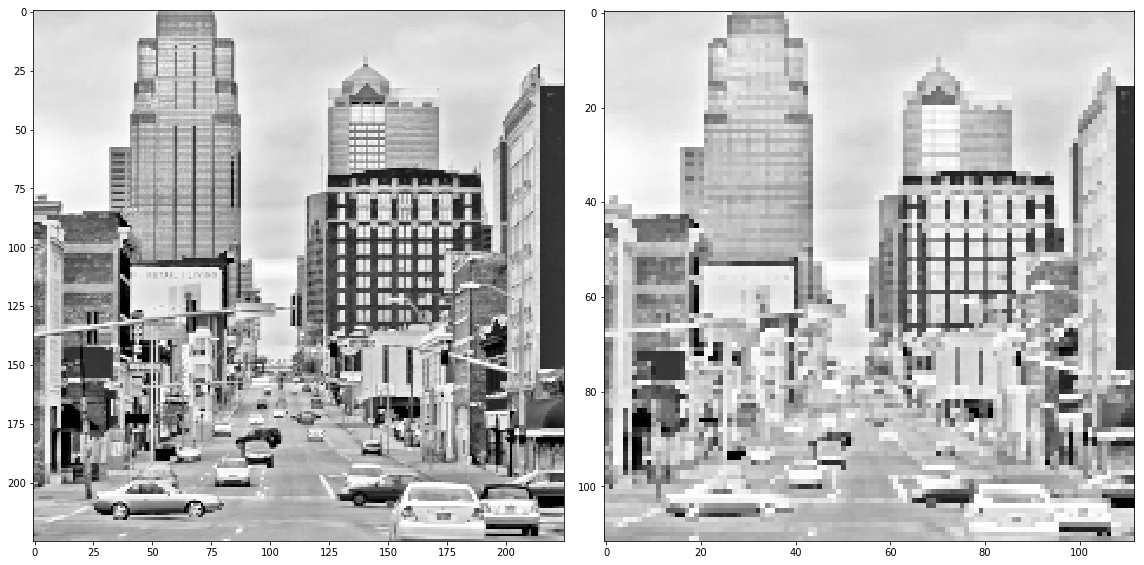

(225, 225)
(112, 112)


In [9]:
max_pool_out_02 = tf.nn.max_pool(max_pool_out, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
plot_side_by_side(np.asarray(max_pool_out[0][:,:,0]), np.asarray(max_pool_out_02[0][:,:,0]))
print(max_pool_out[0][:,:,0].shape)
print(max_pool_out_02[0][:,:,0].shape)

### With "VALID" padding; it's 225 --> 112
what about "SAME"?

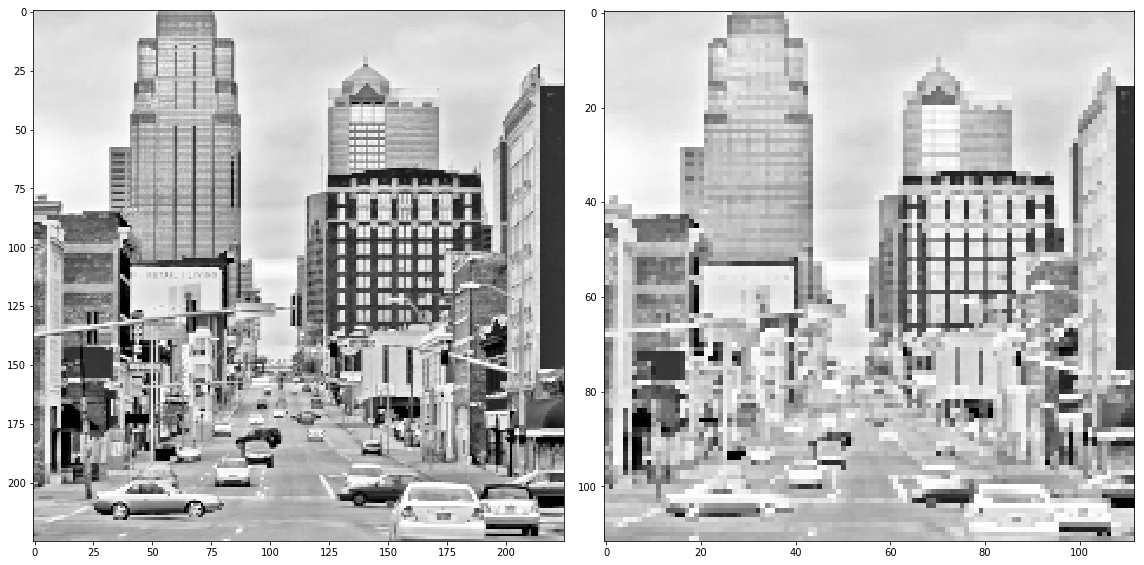

(225, 225)
(113, 113)


In [10]:
max_pool_out_02_s = tf.nn.max_pool(max_pool_out, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
plot_side_by_side(np.asarray(max_pool_out[0][:,:,0]), np.asarray(max_pool_out_02[0][:,:,0]))
print(max_pool_out[0][:,:,0].shape)
print(max_pool_out_02_s[0][:,:,0].shape)

### With same, it's; 225 --> 113
~minor difference, but this can add up.  Notice the loss of information after two max pooling layers though... Though our image is now `113x113` vs the `450x450`.  This is a great example of the cost/benefit of pooling layers (+ feature reduction/faster computation cost, - loss of information, potentially less "valuable")

## Average Pool

In [ ]:
# tf.nn.avg_pool is not working as expected

(225, 225)


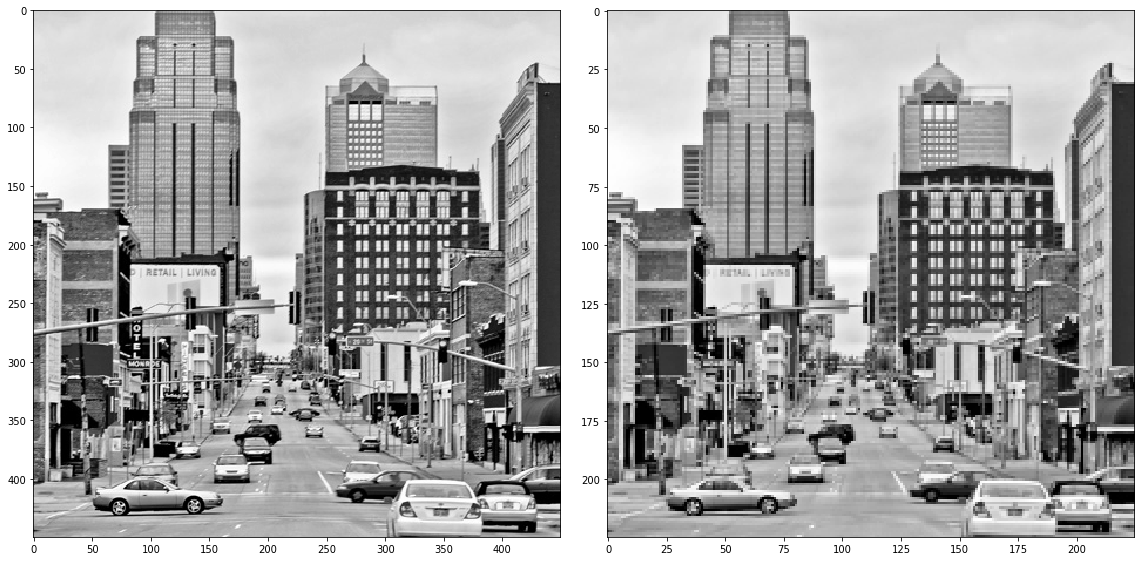

In [52]:
avg_pool_out = tf.nn.fractional_avg_pool(img, [1., 2., 2., 1.])
print(np.asarray(avg_pool_out[0][0][:,:,0]).shape)
plot_side_by_side(img[0][:,:,0], np.asarray(avg_pool_out[0][0][:,:,0]))

In [1]:
jack = np.asarray(avg_pool_out[0][0][:,:,0])
jack = np.expand_dims(jack, axis=-1)
# "batch"
jack = np.expand_dims(jack, axis=0)
print(jack.shape)
avg_pool_out_02 = tf.nn.fractional_avg_pool(jack, [1., 2., 2., 1.])
plot_side_by_side(np.asarray(avg_pool_out[0][0][:,:,0]), np.asarray(avg_pool_out_02[0][0][:,:,0]))

NameError: name 'np' is not defined

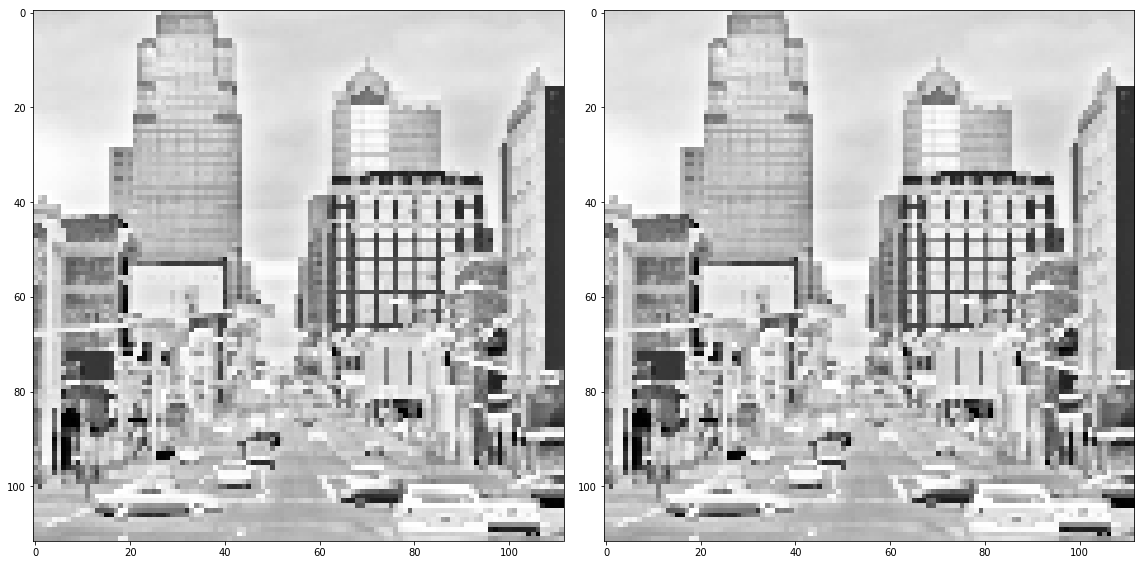

In [80]:
plot_side_by_side(np.asarray(max_pool_out_02[0][:,:,0]), np.asarray(avg_pool_out_02[0][:,:,0]))